In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load data into a dataframe
subsidy = pd.read_excel('subsidy.xlsx', sheet_name='subsidy_disbursements')
subsidy.head()

,National_ID,Age,Gender,Region,Income_Level,Household_Dependents,Monthly_Energy_Consumption_kWh,Subsidy_Eligibility,Subsidy_Type,Amount (NGN),Channel,Date,Wallet_Activity_Status,Wallet_Balance (NGN),Days_Since_Last_Transaction,Avg_Monthly_Wallet_Balance,Suspected_Fraud
0,ID00001,56,Male,Lagos,Low,4,151,1,Food,2977,Mobile Wallet,2022-01-04,Active,4373.0,16.0,5986.0,0
1,ID00001,56,Male,Lagos,Low,4,151,1,Food,2689,Bank Account,2020-12-20,NaN,NaN,NaN,NaN,0
2,ID00001,56,Male,Lagos,Low,4,151,1,Food,3251,Mobile Wallet,2022-06-05,Active,3353.0,76.0,2276.0,0
3,ID00001,56,Male,Lagos,Low,4,151,1,Cash Transfer,6065,Mobile Wallet,2021-05-23,Active,5090.0,55.0,4347.0,0
4,ID00001,56,Male,Lagos,Low,4,151,1,Food,3201,Mobile Wallet,2023-09-17,Inactive,7870.0,3.0,5906.0,0


In [4]:
# Check for data types
subsidy.dtypes

National_ID                               object
Age                                        int64
Gender                                    object
Region                                    object
Income_Level                              object
Household_Dependents                       int64
Monthly_Energy_Consumption_kWh             int64
Subsidy_Eligibility                        int64
Subsidy_Type                              object
Amount (NGN)                               int64
Channel                                   object
Date                              datetime64[ns]
Wallet_Activity_Status                    object
Wallet_Balance (NGN)                     float64
Days_Since_Last_Transaction              float64
Avg_Monthly_Wallet_Balance               float64
Suspected_Fraud                            int64
dtype: object

In [6]:
# Checking for missing values in the dataset
subsidy.isnull().sum()

National_ID                           0
Age                                   0
Gender                                0
Region                                0
Income_Level                          0
Household_Dependents                  0
Monthly_Energy_Consumption_kWh        0
Subsidy_Eligibility                   0
Subsidy_Type                          0
Amount (NGN)                          0
Channel                               0
Date                                  0
Wallet_Activity_Status            53337
Wallet_Balance (NGN)              53337
Days_Since_Last_Transaction       53337
Avg_Monthly_Wallet_Balance        53337
Suspected_Fraud                       0
dtype: int64

In [7]:
# Checking for duplicate rows in the dataset
duplicate_rows = subsidy.duplicated().sum()
duplicate_rows[duplicate_rows >0]

array([], dtype=int64)

In [12]:
# Creating a copy of the subsidy DataFrame for visualisation and explaratoty data analysis
subsidy_clean = subsidy.copy()
# Filling missing values in 'Wallet_Acitivity_Status' with 'No Wallet
subsidy_clean['Wallet_Activity_Status'] = subsidy_clean['Wallet_Activity_Status'].fillna('No Wallet')
# Converting its data type from object to category
subsidy_clean['Wallet_Activity_Status'] = subsidy_clean['Wallet_Activity_Status'].astype('category')

In [13]:
wallet_activities=[
   'Wallet_Balance (NGN)',
   'Days_Since_Last_Transaction',
   'Avg_Monthly_Wallet_Balance'
]
subsidy_clean[wallet_activities] = subsidy[wallet_activities].fillna(0)

In [44]:
subsidy_clean.head()

,National_ID,Age,Gender,Region,Income_Level,Household_Dependents,Monthly_Energy_Consumption_kWh,Subsidy_Eligibility,Subsidy_Type,Amount_(NGN),Channel,Date,Wallet_Activity_Status,Wallet_Balance_(NGN),Days_Since_Last_Transaction,Avg_Monthly_Wallet_Balance,Suspected_Fraud
0,ID00001,56,Male,Lagos,Low,4,151,1,Food,2977,Mobile Wallet,2022-01-04,Active,4373.0,16.0,5986.0,0
1,ID00001,56,Male,Lagos,Low,4,151,1,Food,2689,Bank Account,2020-12-20,No Wallet,0.0,0.0,0.0,0
2,ID00001,56,Male,Lagos,Low,4,151,1,Food,3251,Mobile Wallet,2022-06-05,Active,3353.0,76.0,2276.0,0
3,ID00001,56,Male,Lagos,Low,4,151,1,Cash Transfer,6065,Mobile Wallet,2021-05-23,Active,5090.0,55.0,4347.0,0
4,ID00001,56,Male,Lagos,Low,4,151,1,Food,3201,Mobile Wallet,2023-09-17,Inactive,7870.0,3.0,5906.0,0


In [49]:
# Rename columns
subsidy_clean.rename(columns={'Amount_(NGN)': 'Amount_NGN', 'Wallet_Balance_(NGN)': 'Wallet_Balance_NGN'}, inplace=True)

# Change Date column data type
subsidy_clean['Date'] = pd.to_datetime(subsidy_clean['Date'])

In [54]:
df = subsidy_clean.copy()

In [47]:
subsidy_clean.dtypes

National_ID                               object
Age                                        int64
Gender                                    object
Region                                    object
Income_Level                              object
Household_Dependents                       int64
Monthly_Energy_Consumption_kWh             int64
Subsidy_Eligibility                        int64
Subsidy_Type                              object
Amount_NGN                                 int64
Channel                                   object
Date                              datetime64[ns]
Wallet_Activity_Status                  category
Wallet_Balance_NGN                       float64
Days_Since_Last_Transaction              float64
Avg_Monthly_Wallet_Balance               float64
Suspected_Fraud                            int64
dtype: object

# Exploratory Data Analysis

## Demographic Analysis

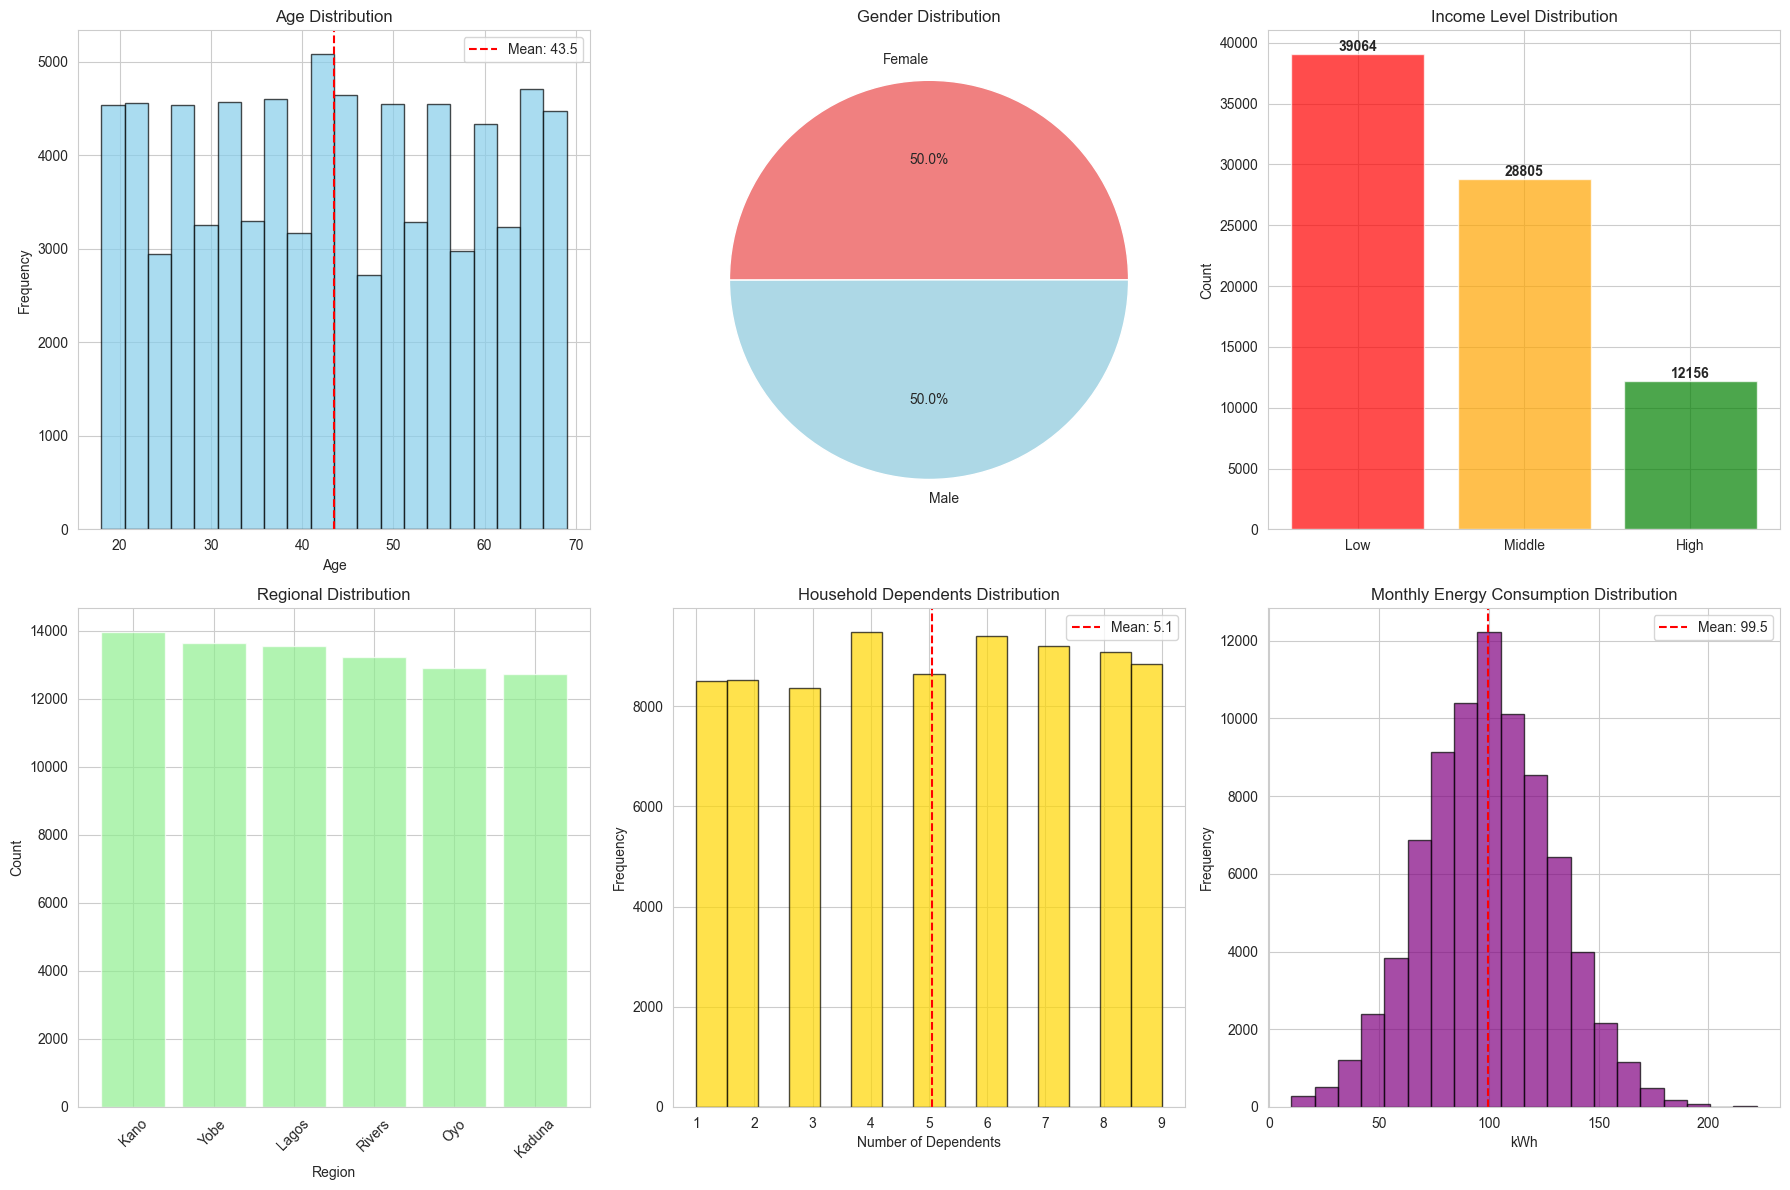

In [61]:
# Set plot style
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Age Distribution
axes[0,0].hist(df['Age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df['Age'].mean(), color='red', linestyle='--', label=f'Mean: {df["Age"].mean():.1f}')
axes[0,0].legend()

# Age Distribution
gender_counts = df['Gender'].value_counts()
axes[0,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', 
                colors=['lightcoral', 'lightblue'])
axes[0,1].set_title('Gender Distribution')

# Income level distribution
income_counts = df['Income_Level'].value_counts()
axes[0,2].bar(income_counts.index, income_counts.values, color=['red', 'orange', 'green'], alpha=0.7)
axes[0,2].set_title('Income Level Distribution')
axes[0,2].set_ylabel('Count')
for i, v in enumerate(income_counts.values):
    axes[0,2].text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

# Regional Distribution
region_counts = df['Region'].value_counts()
axes[1,0].bar(range(len(region_counts)), region_counts.values, color='lightgreen', alpha=0.7)
axes[1,0].set_title('Regional Distribution')
axes[1,0].set_xlabel('Region')
axes[1,0].set_ylabel('Count')
axes[1,0].set_xticks(range(len(region_counts)))
axes[1,0].set_xticklabels(region_counts.index, rotation=45)

# Household dependents distribution
axes[1,1].hist(df['Household_Dependents'], bins=15, alpha=0.7, color='gold', edgecolor='black')
axes[1,1].set_title('Household Dependents Distribution')
axes[1,1].set_xlabel('Number of Dependents')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(df['Household_Dependents'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {df["Household_Dependents"].mean():.1f}')
axes[1,1].legend()

# Energy consumption distribution
axes[1,2].hist(df['Monthly_Energy_Consumption_kWh'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1,2].set_title('Monthly Energy Consumption Distribution')
axes[1,2].set_xlabel('kWh')
axes[1,2].set_ylabel('Frequency')
axes[1,2].axvline(df['Monthly_Energy_Consumption_kWh'].mean(), color='red', linestyle='--',
                    label=f'Mean: {df["Monthly_Energy_Consumption_kWh"].mean():.1f}')
axes[1,2].legend()
    
plt.tight_layout()
plt.show()

## Subsidy Distribution Patterns

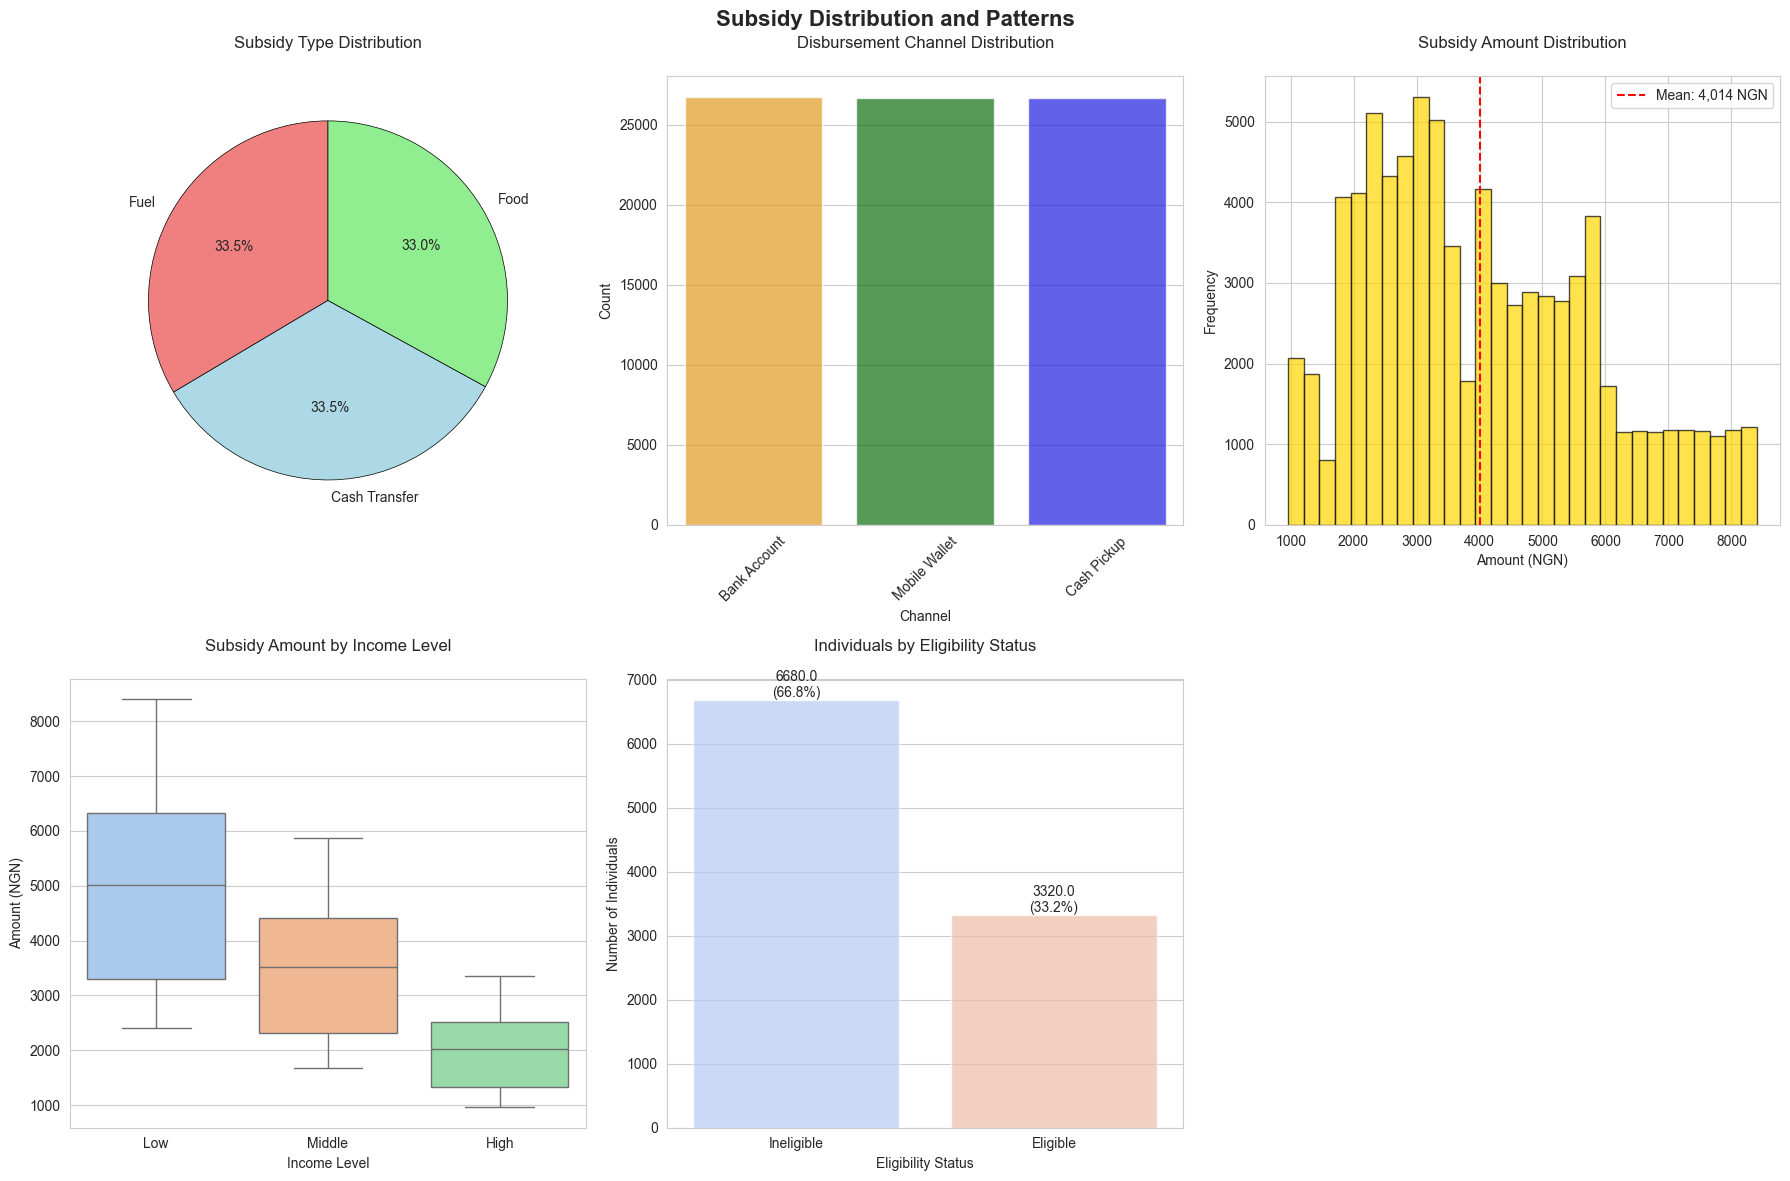

In [88]:
# Create subplots with adjusted layout
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Subsidy Distribution and Patterns', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.4, wspace=0.3) 

# Subsidy Type Distribution 
subsidy_counts = df['Subsidy_Type'].value_counts()
axes[0, 0].pie(
    subsidy_counts.values,
    labels=subsidy_counts.index,
    autopct='%1.1f%%',
    colors=['lightcoral', 'lightblue', 'lightgreen'],
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}
)
axes[0, 0].set_title('Subsidy Type Distribution', pad=20)

# Channel Distribution 
channel_counts = df['Channel'].value_counts()
sns.barplot(
    x=channel_counts.index,
    y=channel_counts.values,
    ax=axes[0, 1],
    palette=['orange', 'green', 'blue'],
    hue=channel_counts.index,
    legend=False,
    alpha=0.7
)
axes[0, 1].set_title('Disbursement Channel Distribution', pad=20)
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xlabel('Channel')
axes[0, 1].tick_params(axis='x', rotation=45)

# --- Plot 3: Amount Distribution (Histogram) 
axes[0, 2].hist(
    df['Amount_NGN'],
    bins=30,
    alpha=0.7,
    color='gold',
    edgecolor='black'
)
axes[0, 2].set_title('Subsidy Amount Distribution', pad=20)
axes[0, 2].set_xlabel('Amount (NGN)')
axes[0, 2].set_ylabel('Frequency')
mean_amount = df['Amount_NGN'].mean()
axes[0, 2].axvline(
    mean_amount,
    color='red',
    linestyle='--',
    label=f'Mean: {mean_amount:,.0f} NGN'
)
axes[0, 2].legend()

# Income Level vs. Amount
income_order = ['Low', 'Middle', 'High']
df['Income_Level'] = pd.Categorical(
    df['Income_Level'],
    categories=income_order,
    ordered=True
)
sns.boxplot(
    data=df,
    x='Income_Level',
    y='Amount_NGN',
    ax=axes[1, 0],
    palette='pastel',
    hue='Income_Level',
    legend=False
)
axes[1, 0].set_title('Subsidy Amount by Income Level', pad=20)
axes[1, 0].set_xlabel('Income Level')
axes[1, 0].set_ylabel('Amount (NGN)')

# Eligibility Status
eligibility_counts = df.groupby('Subsidy_Eligibility')['National_ID'].nunique()
eligibility_percentages = (eligibility_counts / eligibility_counts.sum()) * 100
eligibility_labels = {0: 'Ineligible', 1: 'Eligible'}

sns.barplot(
    x=eligibility_counts.index.map(eligibility_labels),
    y=eligibility_counts.values,
    ax=axes[1, 1],
    palette='coolwarm',
    hue=eligibility_counts.index.map(eligibility_labels),
    legend=False,
    alpha=0.7
)
axes[1, 1].set_title('Individuals by Eligibility Status', pad=20)
axes[1, 1].set_xlabel('Eligibility Status')
axes[1, 1].set_ylabel('Number of Individuals')

# Add count and percentage labels
for i, p in enumerate(axes[1, 1].patches):
    height = p.get_height()
    percentage = eligibility_percentages.iloc[i]
    axes[1, 1].text(
        p.get_x() + p.get_width() / 2.,
        height + 5,
        f'{height}\n({percentage:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=10
    )

axes[1, 2].axis('off') 

plt.tight_layout()
plt.show()

# Machine Learning